<a href="https://colab.research.google.com/github/tylerwilliams1010/Wumbology/blob/master/WUMBOLOGY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd

#Make Dataset
centers = [[0,0], [-1, -1], [1, -1], [0,0.5], [0.4,0.1], [1.5,2], [2,2], [7,6]]
X, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=0.5,
                            random_state=42)
#X = np.vstack([X,[0,2.8]])

#Make UID's 
dfblobs = pd.DataFrame(X)
dfblobs = dfblobs.reset_index()
dfblobs["uid"] = dfblobs.index
dfblobs = dfblobs.drop(["index"], axis=1)

In [43]:
# [WUMBO]
# Weighted UID-filtered anoMaly-Based Outlier detection
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree

def calc_dist_and_density(nn_arr, curr_array, kn):
  # Calculate Average Distance for k-NN
  tree = BallTree(nn_arr)
  dist, ind = tree.query(curr_array,k=kn)
  avg_dist = np.mean(dist)

  # Calculate Inverse Density using Silverman's Rule of Thumb for Bandwidth
  h = 0.9 * nn_arr.std() * len(nn_arr) ** (-1/5)
  density = tree.kernel_density(X=curr_array, h=h)
  density_val = 1/(density[0])
  return avg_dist, density_val

def filter_uid(df, uid_field, curr_uid):
  deduped_array = df[df[uid_field]!=curr_uid].drop([uid_field, "weight", "avg_dist", "Total_Z"], axis=1).to_numpy()
  return deduped_array

def robust_scaler_Z(df, col, alpha):
  min_perc = df[col].quantile(alpha)
  max_perc = df[col].quantile(1 - alpha)

  temp_df = df.loc[(df[col] > min_perc) & (df[col] < max_perc)]
  avg = temp_df[col].mean()
  std = temp_df[col].std()

  df["avg"] = avg
  df["std"] = std

  df["Z_" + col] = (df[col] - df["avg"]) / df["std"]
  df = df.drop(["avg", "std"], axis=1)

  return df

def convert_alpha(alpha):
  # Turn alpha value into Z-Score based on Chebyshev's Inequality
  # for a one-tailed test
  Z = ((alpha * 2) ** -1) ** 0.5 # invert and take square root
  return Z

def wumbo(dataframe, uid_colname, alpha=0.01):
  # [WUMBO] - Weighted UID-filtered anoMaly-Based Outlier detection 
  ##################################################################
  # Wumbo is an anomaly detector designed for large datasets.
  # The algorithm requires no hyperparameters to be chosen except
  # alpha - starting by filtering out similar identities so that
  # one identity can't cluster with itself. Additionally, the
  # primary measurements are kernel density and average distance
  # from its k-Nearest Neighbors. These metrics are then combined
  # and evaluated to determine Outlierness.
  ##################################################################



  # Initialize a temporary and return dataframe 
  temp_df = dataframe.copy()
  
  # Calculate number of k-Neighbors 
  ##############################################################################
  # This is a number that is equal to the square root of distinct count of UID's
  # with a minimum of 5 and a maximum of 50.
  # The number of k-Neighbors scales with the size of the data
  ##############################################################################

  kn = min(max(int(len(dataframe[uid_colname].unique()) ** 0.5),5),50)

  # Calculate Z
  Z = convert_alpha(alpha)

  # Initialize additional columns
  temp_df["weight"] = 0
  temp_df["avg_dist"] = 0
  temp_df["Total_Z"] = 0


  # Iterate through dataframe
  for x in range(len(temp_df.index)):
    # Identify current UID Value
    curr_uid = temp_df.loc[x,uid_colname]

    # Filter out UID's and convert to numpy
    deduped_array = filter_uid(df=temp_df, uid_field=uid_colname,curr_uid=curr_uid)

    # Identify current array and convert to numpy
    curr_array = temp_df.reset_index()
    curr_array = curr_array.loc[curr_array["index"]==x].drop(["index", uid_colname, "weight", "avg_dist", "Total_Z"],axis=1).to_numpy()

    # Find nearest neighbors
    neigh = NearestNeighbors(n_neighbors=kn)
    neigh.fit(deduped_array)
    arr = [x for x in neigh.kneighbors(curr_array)[1][0][:]]
    nn_arr = deduped_array[arr,:]

    # Update avg_dist/inverse_density for row
    avg_dist, inverse_density = calc_dist_and_density(nn_arr=nn_arr, curr_array=curr_array, kn=kn)
    temp_df.loc[x, "avg_dist"] = avg_dist
    temp_df.loc[x, "weight"] = inverse_density

  # Scale and calculate Z for weight/avg_dist
  temp_df = robust_scaler_Z(temp_df, col="weight", alpha=alpha)
  temp_df = robust_scaler_Z(temp_df, col="avg_dist", alpha=alpha)

  # Transform Z_* fields to remove negatives while removing a multiply by zero issue
  temp_df["Z_weight"].apply(lambda x: max(0, x) + 1)
  temp_df["Z_avg_dist"].apply(lambda x: max(0, x) + 1)
  
  # Calculate Weighted Outlier Score
  temp_df["weighted_outlier_score"] = temp_df["Z_weight"] * temp_df["Z_avg_dist"]

  # Transform weighted_outlier_score with Robust Scaler Z calculation
  temp_df["Total_Z"] = robust_scaler_Z(temp_df, col="weighted_outlier_score", alpha=alpha)

  # Initialize Outlier column, determine label via Z calculated before
  temp_df["Outlier"] = 0
  temp_df["Outlier"] = np.where(temp_df["weighted_outlier_score"]>=Z * 2, 1, 0) # Multiplying Z by 2 to solve for bounding issue with the earlier lambda transform

  # Return df with only original columns, Z, and Outlier
  temp_df = temp_df.drop(["weight", "avg_dist", "Total_Z", "Z_weight", "Z_avg_dist", "weighted_outlier_score", "avg", "std"], axis=1)

  return temp_df


In [44]:
# Return Wumbo'd data

wumbo_df = wumbo(dataframe=dfblobs, uid_colname="uid", alpha=0.001)

In [45]:
wumbo_df

,0,1,uid,Z_weighted_outlier_score,Outlier
0,2.012031,2.296263,0,-0.031246,0
1,2.830630,1.771452,1,-0.040737,0
2,-0.803742,0.092317,2,-0.035677,0
3,7.538004,6.010656,3,-0.035428,0
4,-1.378175,-1.711127,4,-0.040756,0
...,...,...,...,...,...
995,-0.040965,-0.151772,995,-0.029174,0
996,0.260971,0.148492,996,-0.028511,0
997,0.981183,-0.448349,997,-0.033494,0
998,6.514172,5.310191,998,-0.041357,0


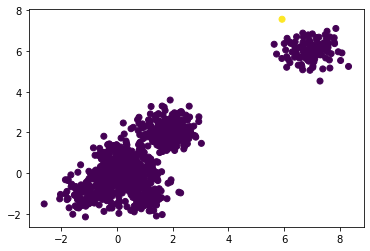

In [46]:
plt.scatter(x=wumbo_df[0], y=wumbo_df[1], c=wumbo_df["Z_weighted_outlier_score"])


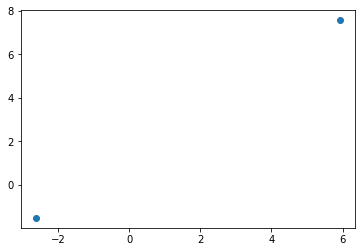

In [47]:
wumbo_df_outliers = wumbo_df.loc[wumbo_df["Outlier"] == 1]

# View Top 1% Outliers
plt.scatter(x=wumbo_df_outliers[0], y=wumbo_df_outliers[1])

In [48]:
print("Total Rows in Dataset: " + str(len(wumbo_df)))
print("Total Outliers: " + str(len(wumbo_df_outliers)))
print("Total Percent Outliers: " + str(int(100*len(wumbo_df_outliers)/len(wumbo_df))) + "%")

Total Rows in Dataset: 1000
Total Outliers: 2
Total Percent Outliers: 0%
